<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/Prophet_case4_230101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Rental Forecasting Using FbProphet

In this dataset, we have features that provide information on users bike ride volume, date of rides, Rain, and Temparature of that date.

We are going to predict the volume of bike ride in the future using time series analysis with Facebook Prophet.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [6]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/data/bikerides_day.csv'
df = pd.read_csv(filename) # important to specify encoding

In [7]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [8]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 4   Entries: 1273



Printing descriptive statistics...

             Volume         Rain         Temp
count  1273.000000  1273.000000  1273.000000
mean   2609.344855     1.945640     6.783975
std    1968.623825     4.505151     7.726084
min      63.000000     0.000000   -11.400000
25%    1185.000000     0.000000     0.700000
50%    2073.000000     0.000000     5.500000
75%    3801.000000     1.400000    13.400000
max    8679.000000    39.500000    25.900000


In [9]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [10]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1273 non-null   object 
 1   Volume  1273 non-null   int64  
 2   Rain    1273 non-null   float64
 3   Temp    1273 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 39.9+ KB
None


Features with missing values in descending order 


Date      0.0
Volume    0.0
Rain      0.0
Temp      0.0
dtype: float64


Good news! We don't have any missing variables. We also see that we have 1273 inputs in our dataset. Let's continue.

In [11]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [12]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Volume') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds     y
0  11/17/2016   933
1  11/18/2016  1197
2  11/19/2016   243
3  11/20/2016   234
4  11/21/2016  2148

The length of your series is:  1273


In [13]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

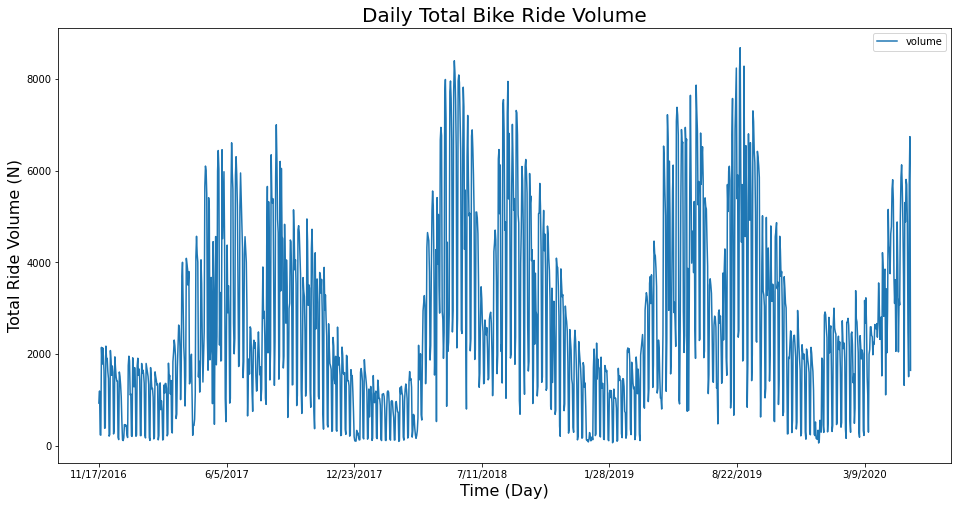

In [14]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "volume"
Figsize = (16,8)
Title = "Daily Total Bike Ride Volume"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Ride Volume (N)'
_fig_plot(df2, X, Y)

OK! The plot is very interesting. It clearly shows that we have some seasonality in our data. We see that in the Summer, the ride volume goes high each year. We'll have to keep that in mind while fitting our forecasting model. It doesn't have an obvious overall trend though. 

In [15]:
shortX = df2[['ds', 'y']].tail(73)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

,dss,yss
1200,3/9/2020,3171
1201,3/10/2020,2673
1202,3/11/2020,3228
1203,3/12/2020,2625
1204,3/13/2020,1506


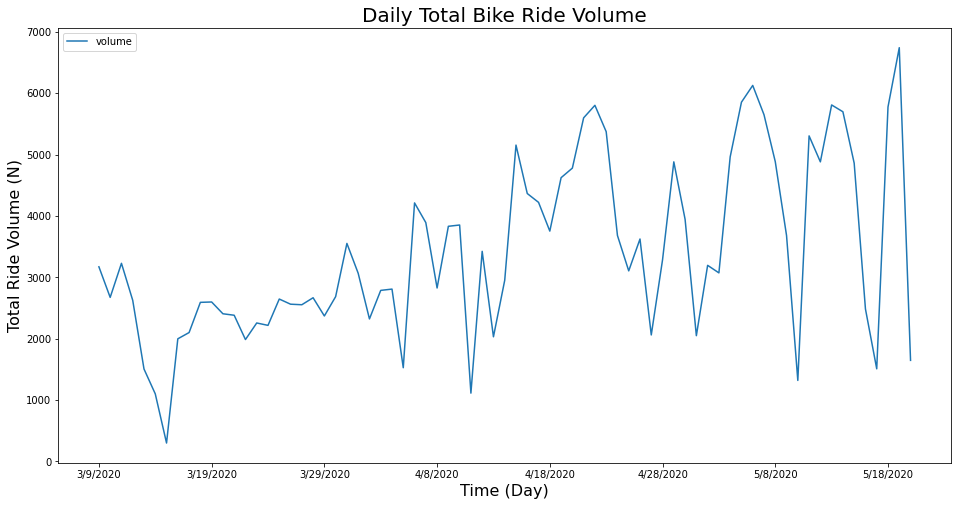

In [16]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "volume"
Figsize = (16,8)
Title = "Daily Total Bike Ride Volume"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Ride Volume (N)'
_fig_plot(shortX, X, Y)

So, the dataset doesn't very clearly shows any daily seasonality or a consistant monthly seasonality. But as we discussed earlier, we got some yearly level seasonality.

In [17]:
# define training dataset
train = df2.copy()

Available hyperparameters are-

* growth='linear', 
* changepoints=None, 
* n_changepoints=25, 
* changepoint_range=0.8, 
* yearly_seasonality='auto', 
* weekly_seasonality='auto', 
* daily_seasonality='auto', 
* holidays=None, 
* seasonality_mode='additive', 
* seasonality_prior_scale=10, 
* holidays_prior_scale=10, 
* changepoint_prior_scale=0.05, 
* mcmc_samples=0, 
* interval_width=0.8, 
* uncertainty_samples=1000, 
* stan_backend=None

In [18]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality='auto', 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/cgg99mm1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/0ezl1mv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73922', 'data', 'file=/tmp/tmp4l2v0v8g/cgg99mm1.json', 'init=/tmp/tmp4l2v0v8g/0ezl1mv2.json', 'output', 'file=/tmp/tmp4l2v0v8g/prophet_model376qe85_/prophet_model-20230101113557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Printing outputs from Prophet prediction...
           ds         yhat   yhat_lower   yhat_upper
0 2016-11-17  1942.496021   667.945104  3223.893756
1 2016-11-18  1531.276916   350.753179  2829.567209
2 2016-11-19  -183.942860 -1451.383533  1040.639008
3 2016-11-20  -101.365309 -1311.744510  1191.326787
4 2016-11-21  2270.900668  1048.505386  3604.567396


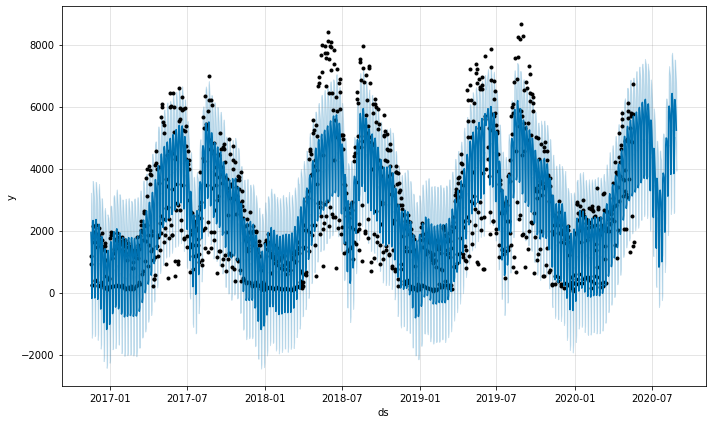

In [19]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [20]:
# Python
plot_plotly(prophet, forecast)

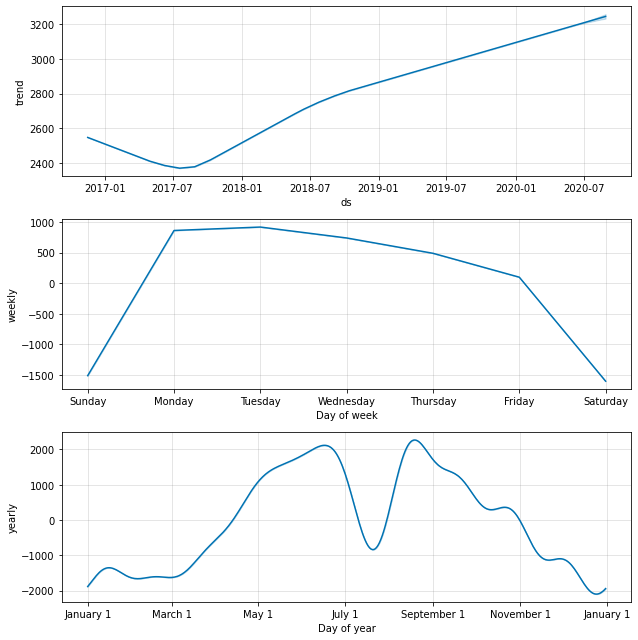

In [21]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [22]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='800 days', period='50 days', horizon = '25 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2019-01-31 00:00:00 and 2020-04-25 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/thd0b3oy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/x61e6kzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85843', 'data', 'file=/tmp/tmp4l2v0v8g/thd0b3oy.json', 'init=/tmp/tmp4l2v0v8g/x61e6kzl.json', 'output', 'file=/tmp/tmp4l2v0v8g/prophet_model1om068bw/prophet_model-20230101113617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/5o32kv3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4l2v0v8g/ofykxkye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [23]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
8,11 days,444318.414419,666.572137,551.599470,0.570189,0.157186,0.459832,0.96
7,10 days,527023.555663,725.963880,567.843602,0.653799,0.208853,0.573534,0.94
9,12 days,560796.202865,748.863274,609.028723,0.461604,0.171174,0.333488,0.90
10,13 days,646041.552268,803.767101,613.710453,0.351897,0.171174,0.249138,0.84
15,18 days,697906.895278,835.408221,722.486697,0.635334,0.236185,0.595064,0.88
